I have identified mouse brain cell type-expressed protein coding genes with pairwise dN/dS calculated from 93 mammalian species against mouse reference genome. Now I want to know which cell types have significantly higher dN/dS. This script calcuated these statistics. 

In [6]:
import numpy as np
import pandas as pd
import glob

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
pd.set_option('display.max_rows', 10)

# Representitive species pairwise dN/dS against mouse reference genome

In [9]:
from scipy import stats
import heapq

In [10]:
species_list=['human','rat','opposum','megabat','tasmaniandevil','cat','pig','avg_93species']
celltype_list=['neuron','endothelia','glia','astrocyte','microglia','oligodendrocyte']

### Descriptive Statistics: median and confidence interval

In [11]:
full_dict = {} # This dictionary stores dataframes for later use 
descriptive_stats_df = pd.DataFrame(
    columns=['Species','Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])
for species in species_list:
    full_dict[species] = {}
    for celltype in celltype_list:
        df=pd.read_csv('../results/mouse.celltype-expressed_genes/protein-coding_w_dNdS/'+species+'/'+celltype+'.tsv',
                       index_col=0, sep='\t')
        full_dict[species][celltype]=df
        arr=df.iloc[:,0].dropna().values
        med=np.median(arr)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        descriptive_stats_df = descriptive_stats_df.append(
            {'Species':species,'Celltype':celltype,'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
            ignore_index=True)


In [12]:
# create an excel file to write descriptive stats
# future analysis with other reference genome can be added to this as a new tab:

# from openpyxl import load_workbook

# book = load_workbook(path)
# writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# writer.book = book

# some_df.to_excel(writer, sheet_name = 'some_sheet_name')

# writer.save()
# writer.close()

path = '../results/celltype-expressed_descriptive_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()


### Inferential statistics: Kruskal Wallis H and Mann Whitney U between celltypes

In [13]:
inferential_stats_df=pd.DataFrame(
    columns=['Species','Kruskal H NEG','Kruskal p NEG',
             'Kruskal H NEAMO','Kruskal p NEAMO',
            'Mann U NG','Mann p NG'])

for species in species_list:

    h_NEG,kp_NEG=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['glia'])

    h_NEAMO,kp_NEAMO=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['astrocyte'],
        full_dict[species]['microglia'],
        full_dict[species]['oligodendrocyte'])
    
    # June 18, 2020: debug on Jan_20_2020-Confirming_w_Couple_Species-Ensembl98Mouse
    # June 24, 2020: debug stats.mannwhitneyu(), include alternative="two-sided", 
    # default "None" is deprecated and generate a smaller p value
    # Now avoid nan values influencing test results.
    # U statistics and p values from Mann Whitney's U test 
    # comparing Neuron-expressed genes and Glia-expressed genes' dN/dS ratios
    u_NG, mp_NG=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['glia'],
        alternative="two-sided")
    
    inferential_stats_df = inferential_stats_df.append(
            {'Species':species,'Kruskal H NEG':h_NEG,'Kruskal p NEG':kp_NEG,
            'Kruskal H NEAMO':h_NEAMO,'Kruskal p NEAMO':kp_NEAMO,
            'Mann U NG':u_NG,'Mann p NG':mp_NG},
            ignore_index=True)

In [14]:
# Create and write to excel file for inferential stats
path = '../results/celltype-expressed_inferential_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()

# Visualization

In [15]:
import matplotlib
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns

In [16]:
matplotlib.rcParams['figure.dpi']= 300

In [17]:
from copy import deepcopy

In [57]:
from matplotlib.ticker import LogLocator, AutoLocator

In [27]:
full_dict['human']['neuron'].sort_values(['hsapiens_dNdS'])

,hsapiens_dNdS
Gene name,
Qk,0.000000
Sf3b3,0.000923
Polr2b,0.000930
Smc3,0.000933
Prpf8,0.000943
...,...
9330159F19Rik,0.714834
Cklf,0.796145
Cabyr,0.818058


In [18]:
graph_dict = deepcopy(full_dict)
graph_df = pd.DataFrame(columns=['dNdS','Species','Celltype'])
for celltype in celltype_list:
    for species in species_list:
        graph_dict[species][celltype].columns=['dNdS']
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Species=species)
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Celltype=celltype)
        graph_df=graph_df.append(graph_dict[species][celltype][['dNdS','Species','Celltype']],ignore_index=True)

In [19]:
sns.set_style('ticks')

In [20]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}

In [21]:
for species in species_list:
    data=graph_df[graph_df['Species']==species]
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
    ax = sns.boxplot(y="dNdS", x="Celltype", data=data,showfliers=False,palette=palette)
    ax.set_yscale('log')
    ax.set_ylim(0.0005,1)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    sns.despine()
    stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",
                        box_pairs=[("endothelia", "neuron"),
                                   ("endothelia", "glia"),
                                   ("glia","neuron"),
                                   ("astrocyte","neuron"),
                                   ("microglia","neuron"),
                                   ("oligodendrocyte","neuron"),
                                   ("astrocyte","microglia"),
                                   ("microglia","oligodendrocyte"),
                                   ("astrocyte","oligodendrocyte")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
    pd.DataFrame(stats[1]).to_csv('../results/mouse.celltype-expressed_genes/protein-coding_w_dNdS/MannWhitney/'+species+'.tsv',sep='\t',index=False)
    ax.set_xlabel("Cell Types")
    ax.set_ylabel("dN/dS of Cell Type-expressed Genes")
    plt.savefig('../figures/MannWhitney/mouse_reference_genome/'+species+'.celltype-expressed.pdf')
    plt.close()

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.618e-08 U_stat=3.369e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.233e-01 U_stat=3.698e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.079e-02 U_stat=3.260e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=9.161e-01 U_stat=3.275e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.940e-05 U_stat=3.964e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.138e-02 U_stat=3.861e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.990e-05 U_stat=3.697e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=7.572e-02 U_stat=3.273e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.99

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=8.744e-08 U_stat=3.099e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.109e-01 U_stat=3.414e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.188e-01 U_stat=2.974e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.704e-01 U_stat=3.041e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.106e-05 U_stat=3.627e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.465e-02 U_stat=3.528e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=3.447e-05 U_stat=3.372e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=6.362e-03 U_stat=2.976e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=8.76

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=8.064e-05 U_stat=2.662e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.316e-01 U_stat=2.877e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.960e-03 U_stat=2.551e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.190e-01 U_stat=2.516e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.117e-02 U_stat=3.112e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.900e-02 U_stat=2.977e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.458e-04 U_stat=2.878e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=8.797e-01 U_stat=2.585e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.45

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.402e-03 U_stat=9.374e+06
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=5.763e-01 U_stat=1.017e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.210e-01 U_stat=9.068e+06
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=5.909e-01 U_stat=9.171e+06
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.625e-03 U_stat=1.080e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.664e-02 U_stat=1.054e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.942e-03 U_stat=1.011e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.856e-01 U_stat=9.069e+06
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.12

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.378e-05 U_stat=2.468e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.551e-01 U_stat=2.685e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=7.637e-03 U_stat=2.384e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.570e-01 U_stat=2.358e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=5.539e-03 U_stat=2.874e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.060e-01 U_stat=2.763e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=8.982e-04 U_stat=2.667e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=6.101e-01 U_stat=2.401e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=8.47

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.657e-08 U_stat=3.189e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.355e-01 U_stat=3.495e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=6.472e-02 U_stat=3.079e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.635e-01 U_stat=3.104e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=3.741e-05 U_stat=3.738e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.466e-02 U_stat=3.634e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.812e-05 U_stat=3.495e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.041e-02 U_stat=3.090e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.72

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.341e-08 U_stat=3.152e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.253e-01 U_stat=3.464e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=8.976e-02 U_stat=3.052e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.099e-01 U_stat=3.090e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.683e-05 U_stat=3.704e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.170e-02 U_stat=3.611e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.802e-05 U_stat=3.461e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.473e-02 U_stat=3.056e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.45

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.930e-10 U_stat=4.259e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=9.191e-02 U_stat=4.713e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.985e-02 U_stat=4.143e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.033e-01 U_stat=4.200e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.290e-06 U_stat=4.991e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=3.531e-03 U_stat=4.865e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.046e-06 U_stat=4.642e+07
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=9.224e-03 U_stat=4.147e+07
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.52

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

[None]

(0.0001, 0.5)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_93species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-expressed Genes')

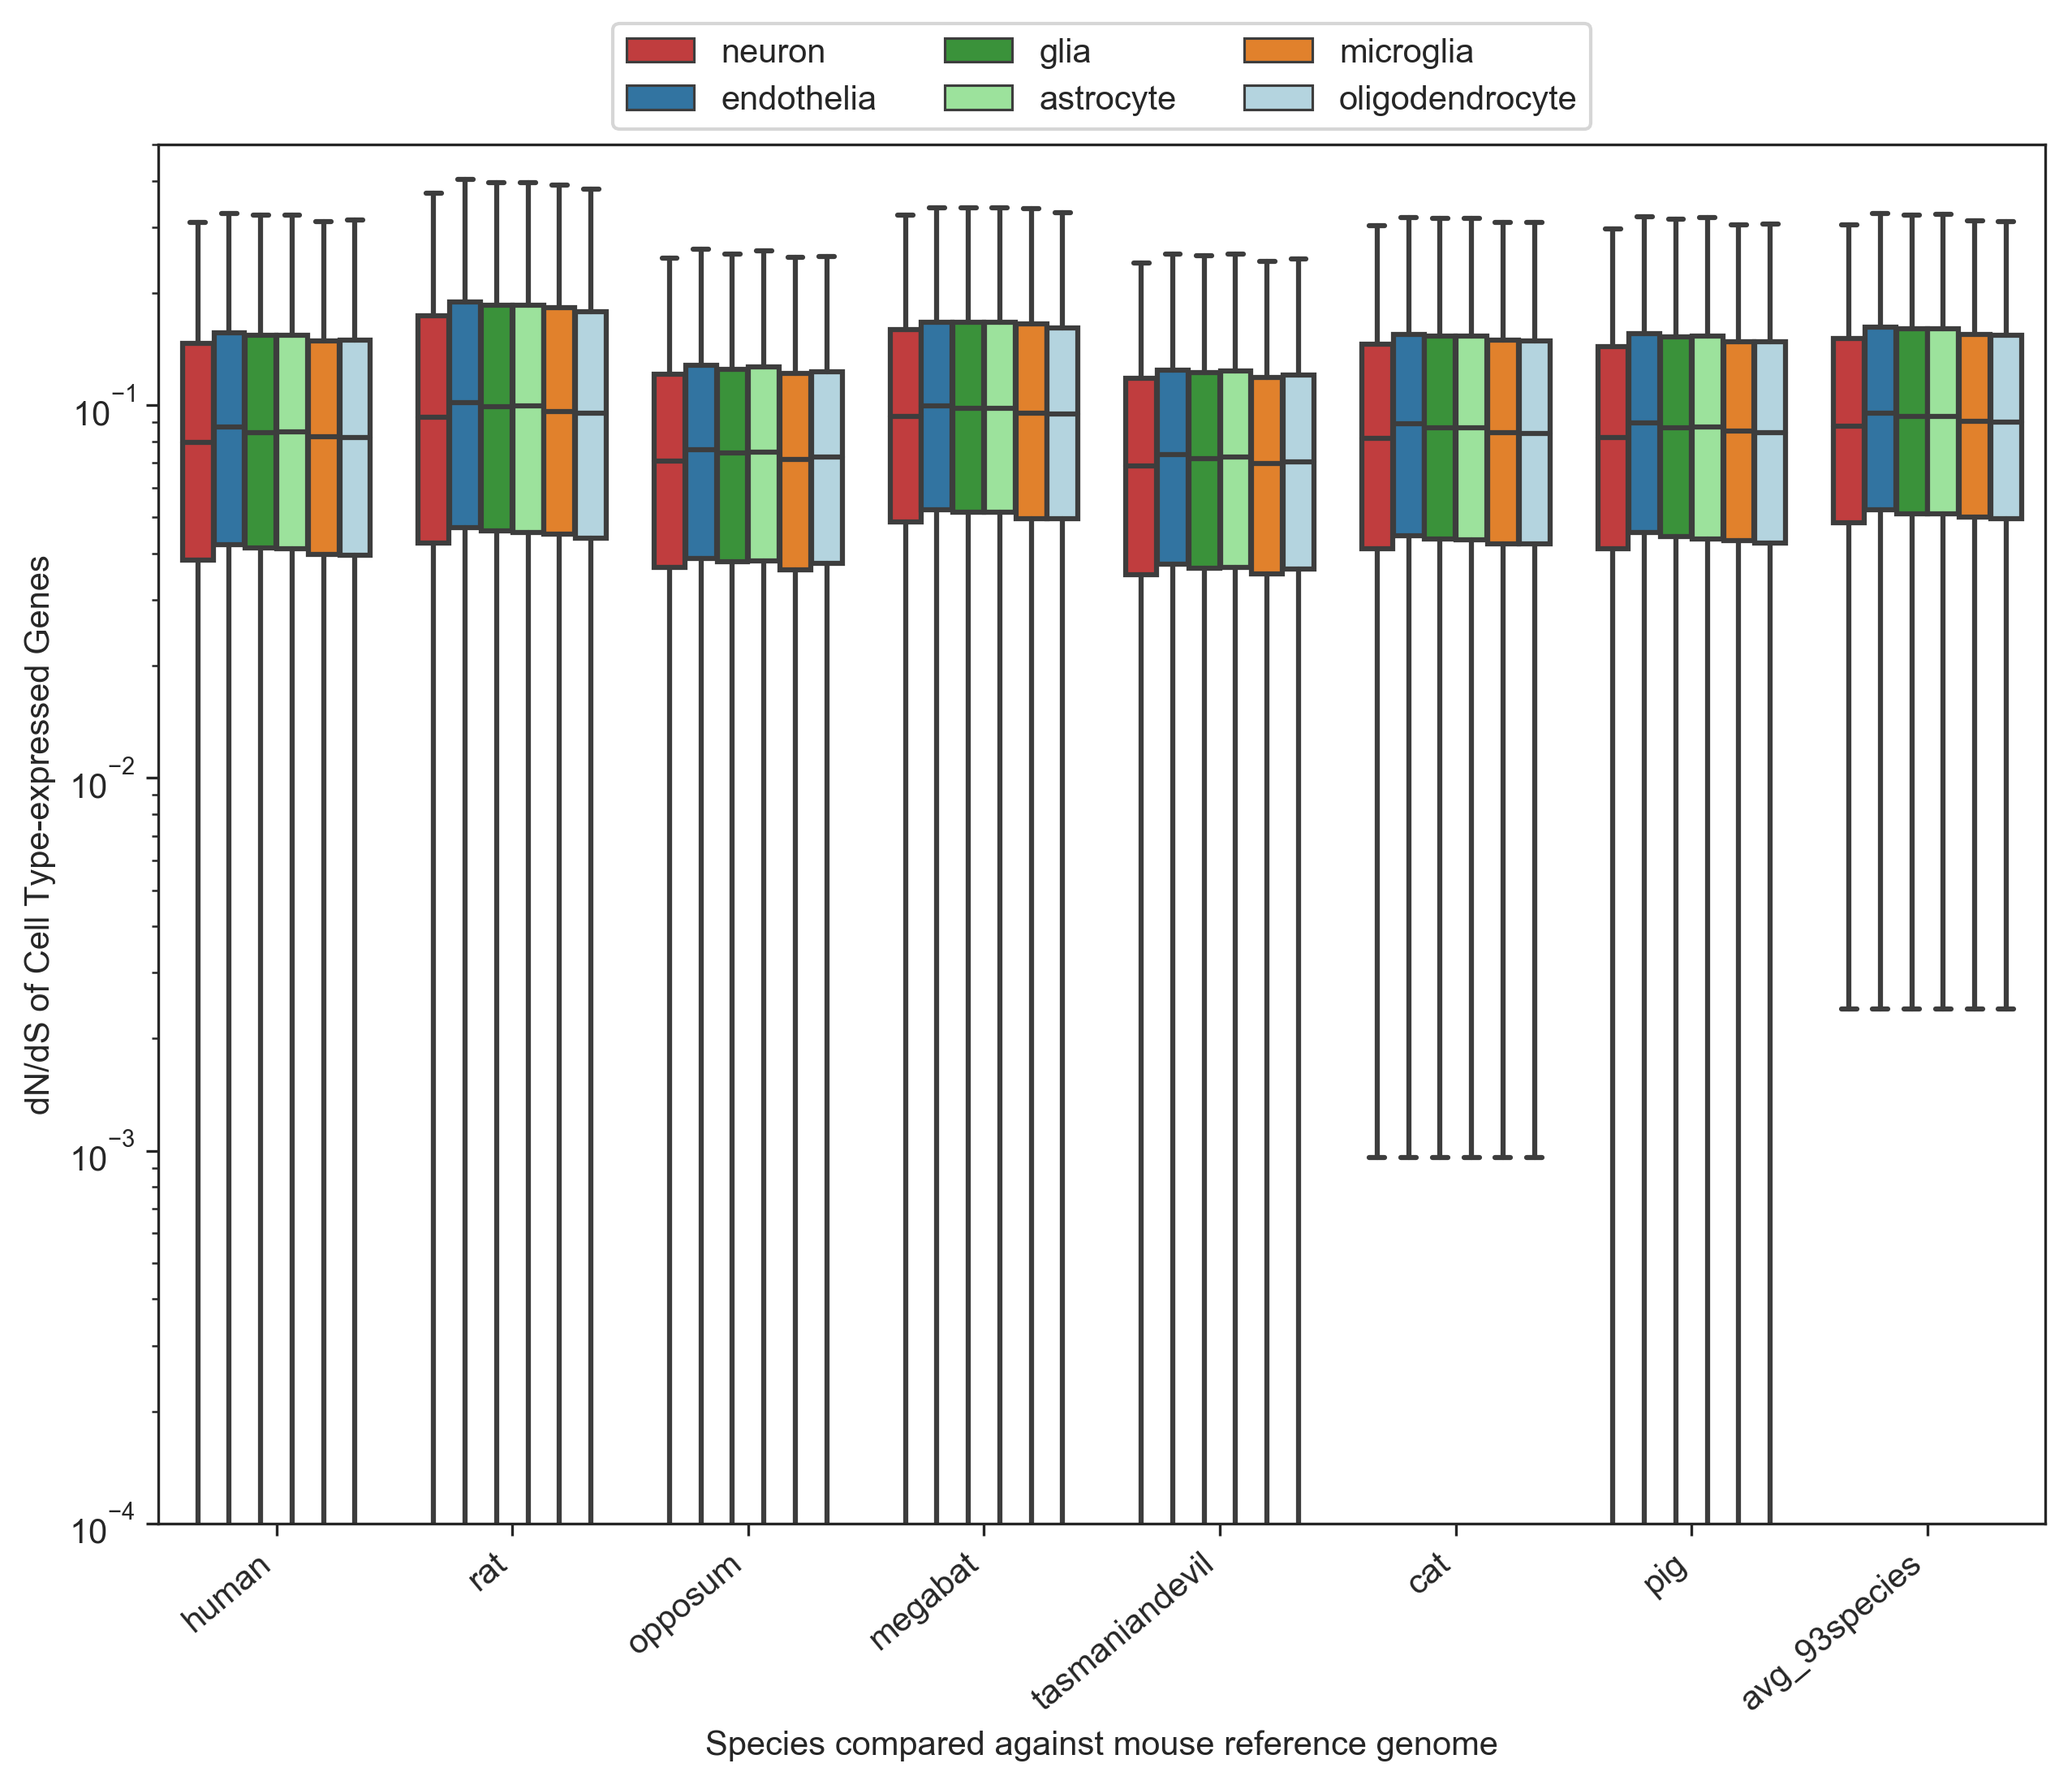

In [69]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxplot(x="Species", y="dNdS", hue="Celltype", data=graph_df, showfliers=False, palette=palette)
ax.set(yscale='log')
ax.set_ylim(0.0001,0.5)
# ax.set_yscale('symlog', linthreshy=0.05)
# ax.yaxis.set_minor_locator(LogLocator(subs=np.arange(2, 10)))
# ax.minorticks_on()
# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=1) 
# ax.yaxis.set_major_locator(locmaj)
# locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.set_ylim(0.00001,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-expressed Genes")
plt.savefig('../figures/mouse.celltype-expressed.boxplots.pdf')
plt.show()